In [2]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 设置路径和初始资金
directory = "/home/jesse/Projects/CWP_RL/02_MVO_Multi_Assets/SP500_10_25"
initial_capital = 10000
min_data_length = 2500  # 至少有 2500 行数据
window_size = 100  # 计算 MVO 时使用的历史天数
rebalance_period = 1  # 每 1 天调整一次仓位
max_selected_stocks = 100  # 持有的最大股票数

print("✅ 初始化完成！")


✅ 初始化完成！


In [3]:
def load_data(directory):
    stock_data = {}
    for ticker in os.listdir(directory):
        if ticker.endswith(".csv"):
            file_path = os.path.join(directory, ticker)
            df = pd.read_csv(file_path)
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df.sort_index(inplace=True)

            if df.shape[0] >= min_data_length:  # 只选择数据足够的股票
                stock_data[ticker.replace(".csv", "")] = df['Close']
    return stock_data

# 读取股票数据
stock_data = load_data(directory)

# 预览前 5 只股票数据
for ticker in list(stock_data.keys())[:5]:
    print(f"📈 {ticker} 数据示例：\n", stock_data[ticker].head())

print(f"\n✅ 成功加载 {len(stock_data)} 只股票的数据！")


📈 TMUS 数据示例：
 Date
2010-12-31    20.466789
2011-01-03    21.179804
2011-01-04    22.557220
2011-01-05    23.108185
2011-01-06    21.552517
Name: Close, dtype: float64
📈 CHRW 数据示例：
 Date
2010-12-31    57.277256
2011-01-03    58.220074
2011-01-04    57.462955
2011-01-05    57.055809
2011-01-06    56.884396
Name: Close, dtype: float64
📈 COO 数据示例：
 Date
2010-12-31    14.016686
2011-01-03    14.143567
2011-01-04    14.029128
2011-01-05    13.947027
2011-01-06    13.947027
Name: Close, dtype: float64
📈 ES 数据示例：
 Date
2010-12-31    19.743599
2011-01-03    19.786953
2011-01-04    19.755991
2011-01-05    19.502066
2011-01-06    19.477299
Name: Close, dtype: float64
📈 HSIC 数据示例：
 Date
2010-12-31    24.074511
2011-01-03    24.619608
2011-01-04    24.329412
2011-01-05    24.313725
2011-01-06    24.572550
Name: Close, dtype: float64

✅ 成功加载 467 只股票的数据！


In [4]:
# 计算每日收益率
returns = pd.DataFrame({ticker: stock_data[ticker].pct_change().dropna() for ticker in stock_data})

# 预览数据
print("📊 收益率数据示例（前5行）：\n", returns.head())

print("\n✅ 收益率计算完成！")


📊 收益率数据示例（前5行）：
                 TMUS      CHRW       COO        ES      HSIC      MKTX  \
Date                                                                     
2011-01-03  0.034838  0.016461  0.009052  0.002196  0.022642 -0.015857   
2011-01-04  0.065034 -0.013004 -0.008091 -0.001565 -0.011787 -0.034180   
2011-01-05  0.024425 -0.007085 -0.005852 -0.012853 -0.000645  0.003034   
2011-01-06 -0.067321 -0.003004  0.000000 -0.001270  0.010645  0.026714   
2011-01-07 -0.026316 -0.001005  0.000178  0.005724 -0.001756 -0.006382   

                 UDR        ED      MCHP       EOG  ...       EMN       KEY  \
Date                                                ...                       
2011-01-03  0.014881 -0.000403  0.016954  0.010283  ...  0.015105  0.023729   
2011-01-04 -0.031420  0.003027 -0.002012 -0.002274  ...  0.017575 -0.011037   
2011-01-05 -0.008651 -0.006640  0.002880  0.002062  ...  0.007369  0.006696   
2011-01-06 -0.007417 -0.001013  0.005744  0.005307  ... -0.002743 -0.

In [ ]:
# 计算年化收益率
def annualized_returns(returns, trading_days=252):
    return returns.mean() * trading_days

# 计算协方差矩阵
def annualized_covariance(returns, trading_days=252):
    return returns.cov() * trading_days

# 目标函数：最大化夏普比率
def objective(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    portfolio_return = np.sum(weights * mean_returns)
    
    # 计算组合波动率
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # 处理负值或 NaN
    if portfolio_variance < 0 or np.isnan(portfolio_variance):
        portfolio_volatility = 1e-6  # 避免 sqrt 计算错误，给一个很小的数
    else:
        portfolio_volatility = np.sqrt(portfolio_variance)

    # 计算夏普比率
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return -sharpe_ratio  # 由于 `minimize` 是最小化，我们取负数

print("✅ MVO 相关函数已定义！")


✅ MVO 相关函数已定义！


In [6]:
# 初始化
portfolio_value = initial_capital
portfolio_values = []
weights_history = []

rebalance_dates = []  # 存储每次调仓的日期

for i in range(window_size, len(returns), rebalance_period):
    # 记录调仓日期 (使用 i-1, 代表用的是前一天的数据)
    rebalance_dates.append(returns.index[i - 1])  

    # 获取窗口数据
    window_returns = returns.iloc[i - window_size:i]

    # 计算年化收益率和标准差
    mean_returns = annualized_returns(window_returns)
    std_returns = window_returns.std() * np.sqrt(252)  # 年化标准差

    # 计算 Sharpe Ratio，并选出前 max_selected_stocks 只股票
    sharpe_ratios = mean_returns / std_returns
    top_stocks = sharpe_ratios.nlargest(max_selected_stocks).index  # 选出前 max_selected_stocks 只股票

    # 仅对选中的股票进行 MVO
    selected_returns = window_returns[top_stocks]
    mean_returns = mean_returns[top_stocks]
    cov_matrix = annualized_covariance(selected_returns)

    # 添加正则项，防止协方差矩阵奇异
    cov_matrix += np.eye(len(mean_returns)) * 1e-6  

    # 初始化权重
    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets

    # 约束条件：权重总和为 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # 权重边界（0 ~ 1）
    bounds = tuple((0, 1) for _ in range(num_assets))

    # 执行优化
    optimized_result = minimize(objective, initial_weights, args=(mean_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

    # 获取最优权重
    optimal_weights = optimized_result.x
    weights_history.append(pd.Series(optimal_weights, index=top_stocks, name=returns.index[i - 1]))

    # 计算投资组合收益（基于下一段时间的实际收益）
    recent_returns = returns.iloc[i:i + rebalance_period][top_stocks].mean()
    portfolio_return = np.sum(optimal_weights * recent_returns)
    portfolio_value *= (1 + portfolio_return)
    portfolio_values.append(portfolio_value)

# 将组合价值记录与日期对应
portfolio_results = pd.DataFrame({'Date': rebalance_dates, 'Portfolio Value': portfolio_values})

# 组合权重记录
weights_df = pd.DataFrame(weights_history)

print("✅ MVO 计算完成，已记录日期和权重！")

# 结果展示
print(portfolio_results.head())
print(weights_df.head())


✅ MVO 计算完成，已记录日期和权重！
        Date  Portfolio Value
0 2011-05-25     10049.219986
1 2011-05-26     10075.551475
2 2011-05-27     10188.626793
3 2011-05-31     10074.709510
4 2011-06-01     10050.689682
                 DPZ      CHTR           ELV           MCO           OKE  \
2011-05-25  0.058250  0.112118  1.649971e-13  2.358367e-14  3.043594e-14   
2011-05-26  0.053945  0.112030  0.000000e+00  7.983356e-13  9.306557e-13   
2011-05-27  0.053785  0.090914  0.000000e+00  0.000000e+00  0.000000e+00   
2011-05-31  0.041355  0.089596  1.837999e-14  0.000000e+00  0.000000e+00   
2011-06-01  0.044145  0.107826  0.000000e+00  0.000000e+00  4.520244e-13   

                  PM       HUM          TECH          ULTA          CPRT  ...  \
2011-05-25  0.142772  0.015316  3.034384e-14  4.491631e-02  1.567058e-03  ...   
2011-05-26  0.154463  0.022911  1.298808e-12  4.522411e-02  1.276307e-03  ...   
2011-05-27  0.157679  0.019722  0.000000e+00  3.732927e-02  0.000000e+00  ...   
2011-05-31  0.1597

In [7]:
# 生成 DataFrame
weights_df = pd.DataFrame(weights_history)
portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=weights_df.index)

# 保存结果
weights_df.to_csv("optimal_weights_history.csv")
portfolio_values_df.to_csv("portfolio_value_history.csv")

print("✅ 结果已保存！")


✅ 结果已保存！


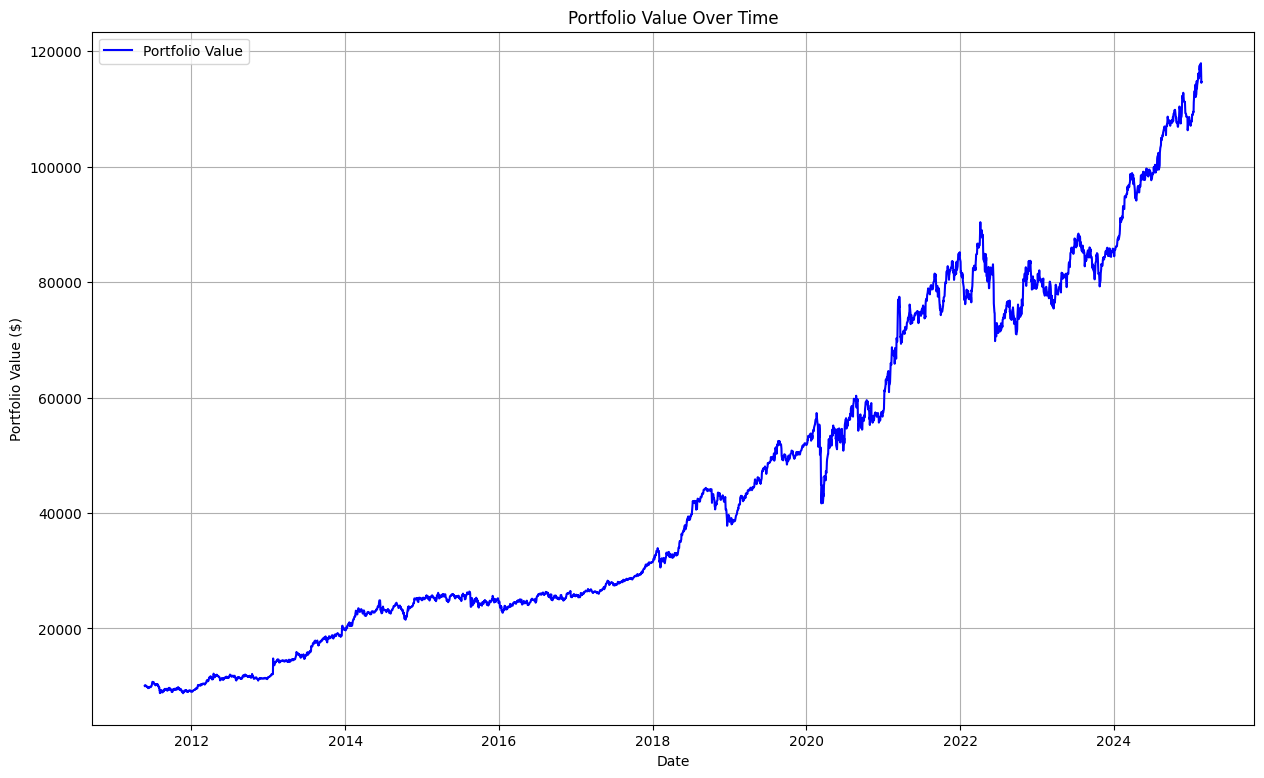

✅ 图表绘制完成！


In [8]:
# 绘制投资组合价值曲线
plt.figure(figsize=(15, 9))
plt.plot(portfolio_values_df.index, portfolio_values_df['Portfolio Value'], label='Portfolio Value', color='b')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("✅ 图表绘制完成！")


[*********************100%***********************]  1 of 1 completed

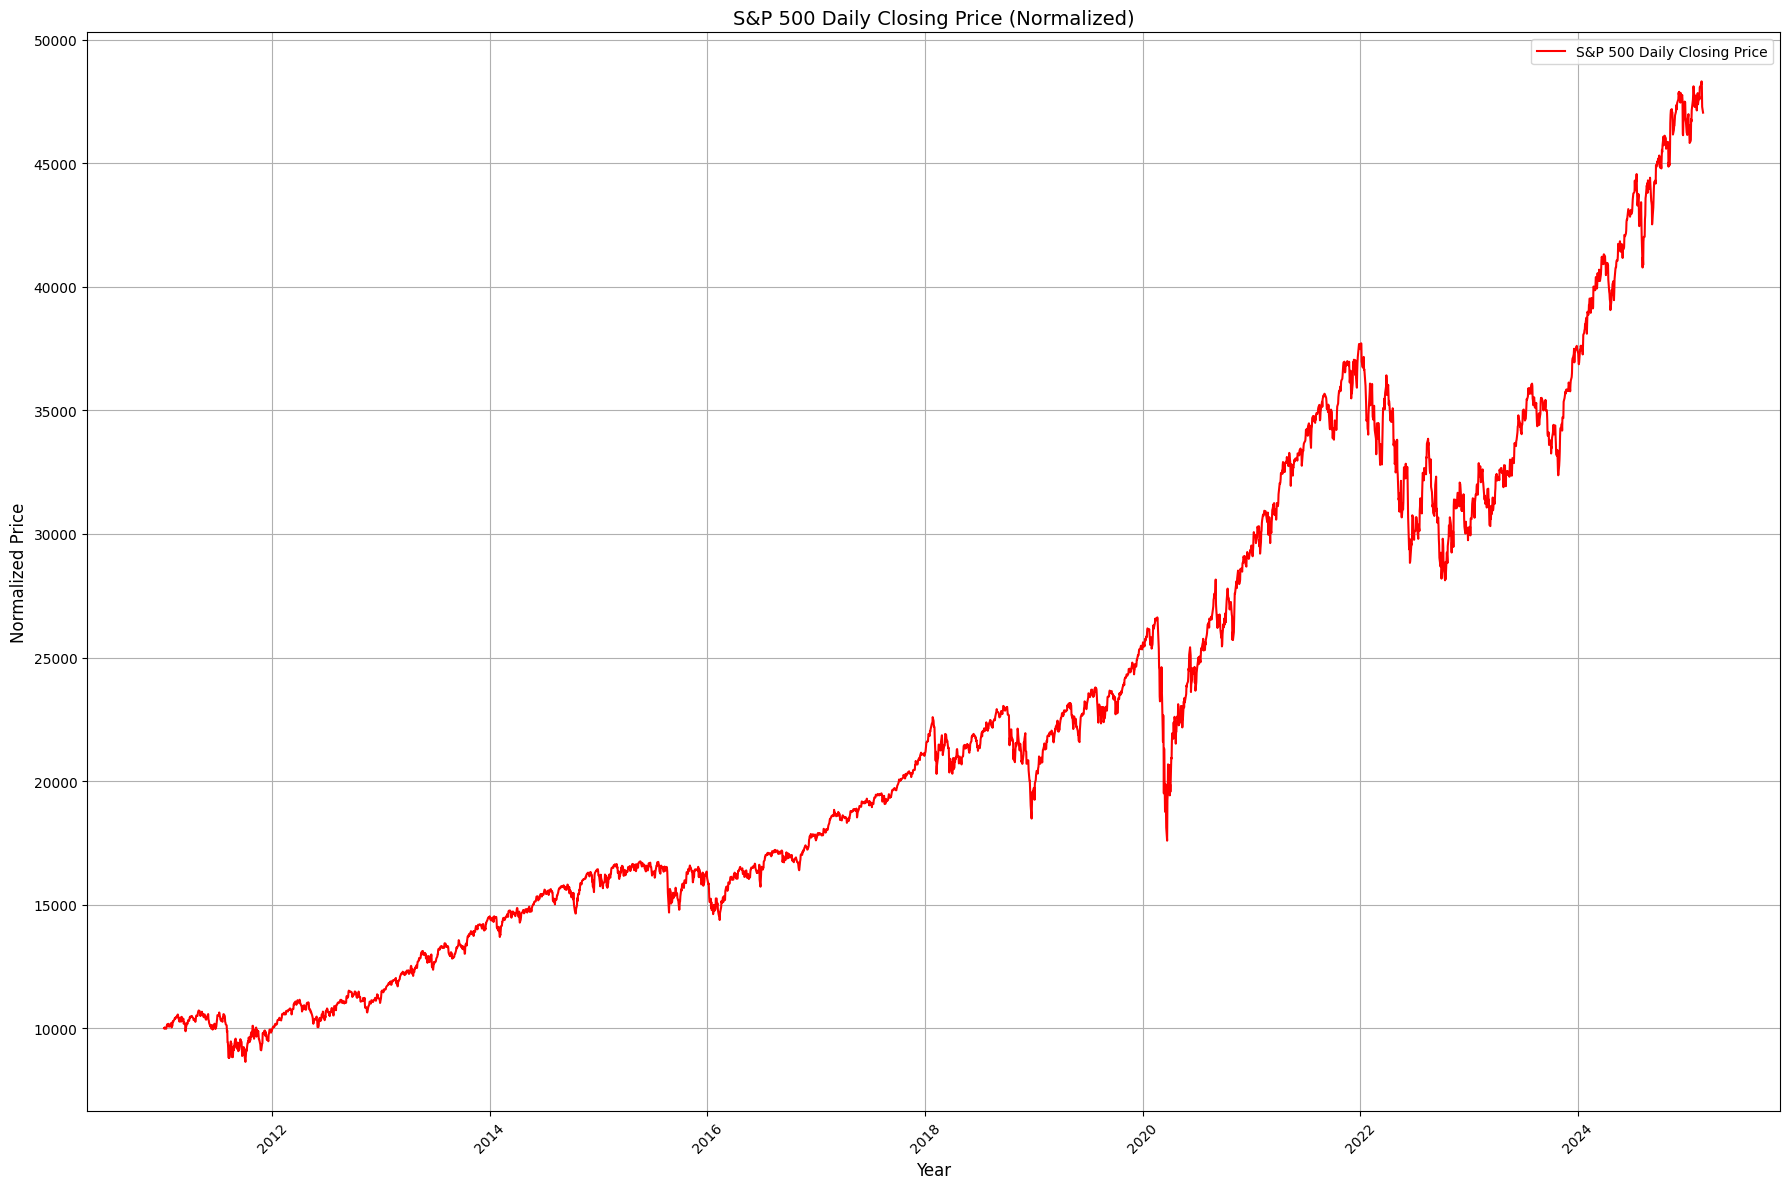

In [10]:
import matplotlib.dates as mdates

# 下载 S&P 500 日收盘价数据
data = yf.download('^GSPC', start='2011-01-03', end='2025-02-25')

# 获取收盘价
close_prices = data['Close']

# 标准化收盘价：使起始点为10000
normalized_close = 10000 * (close_prices / close_prices.iloc[0])

# 创建图表
plt.figure(figsize=(18, 12))
plt.plot(close_prices.index, normalized_close, label='S&P 500 Daily Closing Price', color='r')

# 设置 x 轴为年份
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.title('S&P 500 Daily Closing Price (Normalized)', fontsize=14)

# 格式化 x 轴：显示年份（每 2 年一个刻度）
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # 每 2 年一个刻度
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 只显示年份

# 美化
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # 旋转刻度以防止重叠
plt.tight_layout()

# 展示图像
plt.show()
